In [ ]:
#import dependencies
try:
    import igraph               
except ImportError:
    !pip install python-igraph
    import igraph
import numpy as np
import matplotlib.pyplot as plt
import time

     |████████████████████████████████| 3.2MB 7.1MB/s 


In [ ]:
def locallyVisibleNodes(G, source_node, trace_length, local_visibility):

    '''

    Description: Performs an ego-centric contact-tracing neighborhood search to find which nodes are, in practice, "visible" to us
    
    Parameters:
       
        G (igraph.Graph): the graph
        source_node (int): the ego
        trace_length (int): the distance from ego that we have contact tracing data available for
        local_visibility (float: [0,1] the fraction of nodes within trace_length around ego that we have contact tracing information about

    Returns:
        
        if ego has neighbors:

            all_locally_visible_nodes (np.array): the locally visible nodes

        if ego has no neighbors:

            np.array([source_node])

    '''

    graph_diameter = G.diameter(directed=False)

    if (trace_length >= graph_diameter):

        trace_length = graph_diameter - 1

    immediate_neighbors = G.neighbors(source_node)

    if (len(immediate_neighbors) != 0):

        number_of_immediate_neighbors_we_know_about = int(np.round(len(immediate_neighbors) * local_visibility))

        immediate_neighbors_we_know_about = np.random.choice(immediate_neighbors, size = number_of_immediate_neighbors_we_know_about, replace = False)

        all_nodes_at_max_trace_length = G.neighborhood(vertices = source_node, order = trace_length, mindist = trace_length)

        all_shortests_paths_from_source = []

        for max_trace_length_node in all_nodes_at_max_trace_length:

            all_shortests_paths_from_source.append(G.get_shortest_paths(source_node, max_trace_length_node)[0])

        shortest_paths_we_know_about = []

        for shortest_path in all_shortests_paths_from_source:

            for immediate_neighbor_we_know_about in immediate_neighbors_we_know_about:

                is_immediate_neighbor_in_shortest_path = immediate_neighbor_we_know_about in shortest_path

                if (is_immediate_neighbor_in_shortest_path == True):

                    shortest_paths_we_know_about.append(shortest_path)

        if (len(shortest_paths_we_know_about) == 0):

            all_locally_visible_nodes = np.array([]) #should this be np.array([source_node]) ? (we still want to include ego)

        else:
            
            all_locally_visible_nodes = np.unique(np.concatenate(shortest_paths_we_know_about))

        return all_locally_visible_nodes

    else:

        return np.array([source_node])

In [ ]:
def SIR(N, k, p, h, i, r, b, t, global_visibility, local_visibility, trace_length):

    '''
    
    Description: Runs a probabilistic SIR epidemic model on a Watts-Strogatz small-world network using igraph
    
    Parameters:

        * INITIAL GRAPH PARAMATERS
            N (int): the number of nodes in the network
            k (int): each node is connected to k nearest neighbors in ring topology
            p (float): [0:1] the Watts-Strogatz rewiring probability
            h (float): [0:1] the initial health of the population
        
        * PROBABILISTIC PRAMATERS
            i (float): [0:1] how infectious the disease is (infectiousness)
            r (float): [0:1] the probability of recovery; assume immunity if recovered
            b (float): [0:1] the probability of of an edge breaking and rewiring to a healthy node
            t (float): [0:1] the probability of choosing to close a triangle (if possible) in the rewiring process

        * CONTACT TRACING PARAMATERS
            global_visibility (float): [0,1] the fraction of the population that we have contact tracing information about at each time step; the members of the population are chosen randomly without any preference to degree or status
            local_visibility (float: [0,1] the fraction of nodes within trace_length around an infected individual that we have contact tracing information about
            trace_length (int): the distance from an infected individual that we have contact tracing data available for
            
    Returns:
        results (complex list object): the final return object is a list that contains useful simulation results:
        results[0] = time: (int) the amount of dimensionless time it takes for the population to become epidemic free 
        results[1] = S_population_history: (list) a list that contains the susceptible node population history
        results[2] = I_population_history: (list) a list that contains the infected node population history
        results[3] = R_population_history: (list) a list that contains the recovered node population history
        results[4] = transitvity_history: (list) a list that contains the transitivity history of the graph
        results[5] = G: (igraph.Graph) the graph in its final form
        results[6] = node_history (list) the number of nodes in the graph over time
        results[7] = edge_history (list) the number of edges in the graph over time
        results[8] = cluster_history (list) the number of clusters in the graph over time

    Legend:
        -1: susceptible
         0: infected
         1: recovered
        
    '''

    #create private paramater: transitivity resolution
    #only recalculate transitivity at this predefined time resolution 
    #increase this number for faster runtimes
    transitivity_resolution = 50

    #create the graph
    G = igraph.Graph.Watts_Strogatz(1, N, k, p)

    #get the number of initial S and I nodes
    number_of_nodes_initially_susceptible = int(h * N)
    number_of_nodes_initially_infected = N - number_of_nodes_initially_susceptible

    #get the initial transitivity of the graph
    transitivity = G.transitivity_undirected("zero")

    #instantiate return object items
    time = 0
    S_population_history = []
    I_population_history = []
    R_population_history = []
    transitivity_history = []
    node_history = []
    edge_history = []
    cluster_history = []

    #populate the return objects with initial data
    S_population_history.append(number_of_nodes_initially_susceptible)
    I_population_history.append(number_of_nodes_initially_infected)
    R_population_history.append(0)
    transitivity_history.append(transitivity)
    node_history.append(G.vcount())
    edge_history.append(G.ecount())
    cluster_history.append(len(G.clusters()))

    #create the node statuses object and fill it with the initially randomized S/I statuses
    initial_node_statuses = np.zeros(N, dtype = int)
    initial_node_statuses[:number_of_nodes_initially_susceptible] = -1
    np.random.shuffle(initial_node_statuses)

    #assign the initial statuses 
    G.vs["status"] = initial_node_statuses

    #get the number of people we have contact tracing information about
    number_of_nodes_we_know_about = int(np.round(N * global_visibility))

    #while there are still infected people in the population
    while(0 in G.vs["status"]):

        #randomly select a node (vertex)
        n = np.random.choice(G.vs())

        #randomly choose the nodes that we have contact information about
        nodes_we_know_about = np.random.choice(N, size = number_of_nodes_we_know_about, replace=False)

        #assert boolean statement for this node
        dynamics_could_have_occured = False

        #hand off the graph structure to manipulate
        G_new = G.copy()

        #get the status of the current node
        status_of_current_node = n["status"]

        #if the current node is recovered, continue to the next node (dynamics have no chance of occuring)
        if (status_of_current_node == 1):

            continue

        #if this node is susceptible
        elif (status_of_current_node == -1):

            #reassert boolean statement
            dynamics_could_have_occured = True

            #get the neighbors of this node
            neighbors_of_current_node = np.asarray(G.neighbors(n))

            #get the number of neighbors
            number_of_neighbors = len(neighbors_of_current_node)

            #if there are no neighbors, continue to the next node
            if (number_of_neighbors == 0):

                continue

            #get the statuses of all of the neighbors
            statuses_of_neighbors = np.array(G.vs["status"])[neighbors_of_current_node]

            #get the number of infected neighbors
            number_of_infected_neighbors = np.count_nonzero(statuses_of_neighbors == 0)

            #if there were no infected neighbors, continue to the next node
            if (number_of_infected_neighbors == 0):

                continue  

            #get the indices of the infected neighbors
            indices_of_infected_neighbors = np.argwhere(statuses_of_neighbors == 0).flatten()

            #get the infected neighbors (their node numbers)
            infected_neighbors = neighbors_of_current_node[indices_of_infected_neighbors]

            #get the infection decision (complex contagion)
            probability_of_infection = i * (number_of_infected_neighbors / number_of_neighbors)
            infection_decision = np.random.binomial(1, probability_of_infection)

            #if the infection decision was successful, update the status of this susceptible node
            if (infection_decision == 1):

                G_new.vs[n.index]["status"] = 0

            #get all of the healthy nodes (S or R) in the population
            S_nodes = np.argwhere(np.array(G.vs["status"]) == -1)
            R_nodes = np.argwhere(np.array(G.vs["status"]) == 1)
            healthy_nodes = np.concatenate((S_nodes, R_nodes), axis = None)
            
            #for each infected neighbor
            for infected_neighbor in infected_neighbors:

                #get the breaking decision for this infected neighbor
                breaking_decision = np.random.binomial(1, b)

                #if this break was successful
                if (breaking_decision == 1):

                    #break this edge
                    G_new.delete_edges([(n, infected_neighbor)])

                    #get the transitivity rewiring decision
                    transitivity_rewiring_decision = np.random.binomial(1, t)

                    #if the transitivity rewiring decision has succeeded
                    if (transitivity_rewiring_decision == 1):

                        #get all of the shortest paths from this current S node to all of the healthy nodes
                        shortest_paths = np.asarray(G.shortest_paths(n, healthy_nodes)[0])

                        #out of all of the shortest paths, get the indices of those whose distance is 2
                        indices_with_distance_2 = np.argwhere(shortest_paths == 2).flatten()

                        #if there are no healthy nodes at distance 2 put the edge back 
                        if (len(indices_with_distance_2) == 0):

                            G_new.add_edge(n, infected_neighbor)
                        
                        #else, there are healthy nodes at distance 2
                        else:

                            #from those indices, get the node numbers of all of the healthy nodes at distance 2
                            healthy_nodes_at_distance_2 = healthy_nodes[indices_with_distance_2]

                            #select a random healthy node at distance 2 to rewire to
                            random_healthy_node_at_distance_2 = np.random.choice(healthy_nodes_at_distance_2)

                            #make sure this edge doesn't already exist
                            while (G.are_connected(n, random_healthy_node_at_distance_2)):

                                random_healthy_node_at_distance_2 = np.random.choice(healthy_nodes_at_distance_2)

                            #rewire
                            G_new.add_edge(n, random_healthy_node_at_distance_2)

                    #else, the transitivity rewiring decision has failed
                    else:

                        #pick a healthy node at random to rewire to
                        random_healthy_node = np.random.choice(healthy_nodes)

                        #make sure this random node is not the current node (no loops) and that this edge doesn't already exist
                        while (random_healthy_node == n or G.are_connected(n, random_healthy_node)):

                            random_healthy_node = np.random.choice(healthy_nodes)

                        #rewire this S node to that healthy node
                        G_new.add_edge(n, random_healthy_node)

        #else, this current node must be infected (status_of_current_node == 0)
        else:

            #reassert boolean statement
            dynamics_could_have_occured = True

            #get recovery decision
            recovery_decision = np.random.binomial(1, r)

            #if the recovery was successful
            if (recovery_decision == 1):

                #update this node's status
                G_new.vs[n.index]["status"] = 1

            #if this node is one of the nodes we have information about
            if (n.index in nodes_we_know_about):

                #get all of the locally visible nodes
                all_locally_visible_nodes = locallyVisibleNodes(G, n.index, trace_length, local_visibility)

                #if there are any locally visibile nodes
                if (len(all_locally_visible_nodes) != 0):

                    #instantiate storage to keep track of infected nodes to delete if they are locally visible to us
                    infected_trace_nodes_to_delete = []

                    #for every node in the trace length
                    for locally_visible_node in all_locally_visible_nodes:

                        #get the status of this node
                        status_of_locally_visible_node = G.vs[locally_visible_node]["status"]

                        #if this node in the trace length is infected and we know about it
                        if (status_of_locally_visible_node == 0 and n.index in nodes_we_know_about):

                            #append to storage
                            infected_trace_nodes_to_delete.append(locally_visible_node)

                    #delete these infected trace nodes
                    G_new.delete_vertices(infected_trace_nodes_to_delete)

        #if dynamics could have occured
        if (dynamics_could_have_occured == True):

            #update the time
            time = time + 1

            #update population histories
            S_population_history.append(np.count_nonzero(np.array(G_new.vs["status"]) == -1))
            I_population_history.append(np.count_nonzero(np.array(G_new.vs["status"]) == 0))
            R_population_history.append(np.count_nonzero(np.array(G_new.vs["status"]) == 1))

            #hand off the new graph
            G = G_new.copy()

            #update node/edge/cluster histories
            node_history.append(G.vcount())
            edge_history.append(G.ecount())
            cluster_history.append(len(G.clusters()))

            #if we are destined to once again recalculate transitivity
            if ((time % transitivity_resolution) == 0):

                #recalculate the transitivity
                transitivity = G.transitivity_undirected("zero")

                #append this new transitvity to the history
                transitivity_history.append(transitivity)

    #create the return object
    results = [time, S_population_history, I_population_history, R_population_history, transitivity_history, G, node_history, edge_history, cluster_history]
   
    return results

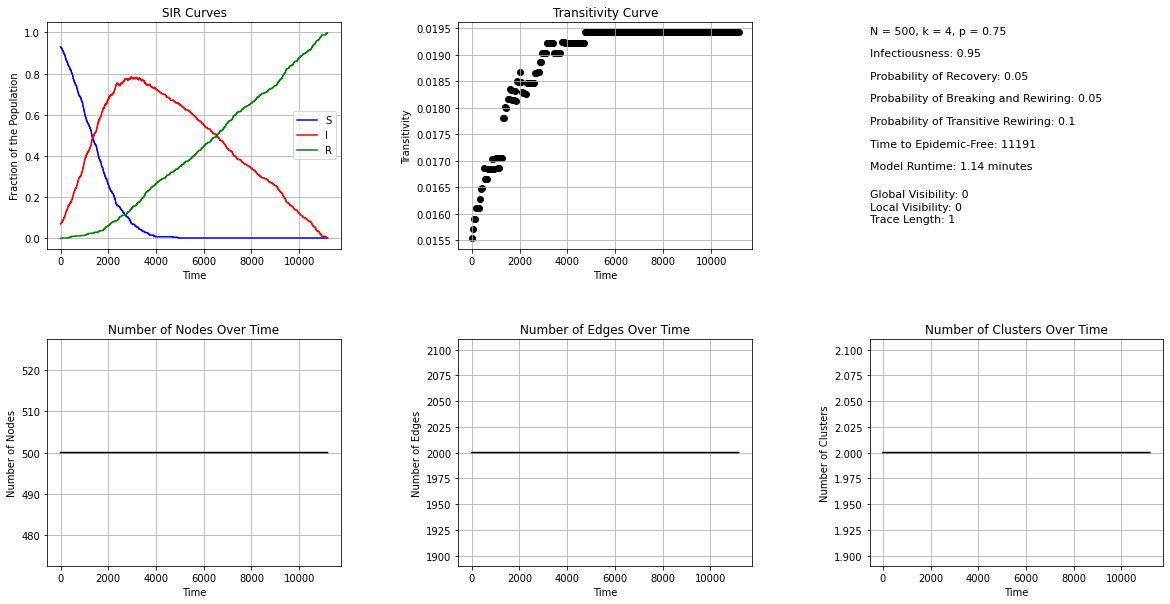

In [ ]:
#@title SIR Model

#define graph parameters
N =  500#@param {type:"integer"}
k =  4#@param {type:"integer"}
p = 0.75 #@param {type:"slider", min:0, max:1, step:0.25}

#define proabilistic parameters
h = 0.93 #@param {type:"slider", min:0, max:1, step:0.001}
i = 0.95 #@param {type:"slider", min:0, max:1, step:0.05}
r = 0.05 #@param {type:"slider", min:0, max:1, step:0.05}
b = 0.05 #@param {type:"slider", min:0, max:1, step:0.05}
t = 0.1 #@param {type:"slider", min:0, max:1, step:0.05}
global_visibility = 0 #@param {type:"slider", min:0, max:1, step:0.1}
local_visibility =  0 #@param {type:"slider", min:0, max:1, step:0.1}
trace_length =  1#@param {type:"integer"}

start = time.process_time()
results = SIR(N, k, p, h, i, r, b, t, global_visibility, local_visibility, trace_length);
runtime = time.process_time() - start

#set up subplots
fig, ((ax1,ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2,3,figsize=(20,10))
plt.subplots_adjust(wspace = 0.4, hspace = 0.4)

#get the time axis
time_axis = np.arange(0, results[0]+1)

#ax1 details
ax1.set_title("SIR Curves")
ax1.set_ylabel("Fraction of the Population")
ax1.set_xlabel("Time")
ax1.grid("on")
ax1.plot(time_axis, np.array(results[1])/N, c = 'b', label = "S")
ax1.plot(time_axis, np.array(results[2])/N, c = 'r', label = "I")
ax1.plot(time_axis, np.array(results[3])/N, c = 'g', label = "R")
ax1.set_ylim(-0.05,1.05)
ax1.legend()

#ax2 details
ax2.set_title("Transitivity Curve")
ax2.grid("on")
ax2.set_xlabel("Time")
ax2.set_ylabel("Transitivity")
transitivity_time_axis = (np.arange(0, len(results[4]))) * 50
ax2.scatter(transitivity_time_axis, results[4], c = 'k')

#ax3 details
myfontsize = 11
ax3.axis("off");
ax3.text(0, 0.95, "N = " + str(N) + ", k = " + str(k) + ", p = " + str(p) , fontsize = myfontsize)
ax3.text(0,0.85,"Infectiousness: " + str(i) , fontsize = myfontsize)
ax3.text(0, 0.75, "Probability of Recovery: " + str(r), fontsize = myfontsize)
ax3.text(0,0.65,"Probability of Breaking and Rewiring: " + str(b), fontsize = myfontsize)
ax3.text(0, 0.55, "Probability of Transitive Rewiring: " + str(t), fontsize = myfontsize)
ax3.text(0, 0.45, "Time to Epidemic-Free: " + str(results[0]), fontsize = myfontsize)
ax3.text(0, 0.23, "Global Visibility: " + str(global_visibility), fontsize = myfontsize)
ax3.text(0, 0.17, "Local Visibility: " + str(local_visibility), fontsize = myfontsize)
ax3.text(0, 0.12, "Trace Length: " + str(trace_length), fontsize = myfontsize)

#ax4 details
ax4.grid("on")
ax4.plot(time_axis, results[6], c = 'k')
ax4.set_title("Number of Nodes Over Time")
ax4.set_xlabel("Time")
ax4.set_ylabel("Number of Nodes")

#ax5 details
ax5.grid("on")
ax5.plot(time_axis, results[7], c = 'k')
ax5.set_title("Number of Edges Over Time")
ax5.set_xlabel("Time")
ax5.set_ylabel("Number of Edges")

#ax6 details
ax6.grid("on")
ax6.plot(time_axis, results[8], c = 'k')
ax6.set_title("Number of Clusters Over Time")
ax6.set_xlabel("Time")
ax6.set_ylabel("Number of Clusters")



if (runtime < 60):
    ax3.text(0, 0.35, "Model Runtime: " + str(round(runtime,2)) + " seconds", fontsize = myfontsize);
elif (runtime >= 60 and runtime < 3600):
    ax3.text(0, 0.35, "Model Runtime: " + str(round((runtime / 60),2)) + " minutes", fontsize = myfontsize);
else:
    ax3.text(0, 0.35, "Model Runtime: " + str(round((runtime / 3600),2)) + " hours", fontsize = myfontsize);